# T cells data
## Xiaonan Wang
## 03Aug2017

In [3]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.5.1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.7.1 louvain==0.6.1


## T-cells session

In [10]:
%%time
Tcells_data = sc.read("Tcells_cnt.txt", cache=True, delimiter="\t")

CPU times: user 12min 49s, sys: 1min 7s, total: 13min 56s
Wall time: 14min 45s


In [11]:
Tcells_data.var_names = np.genfromtxt("genes.tsv", dtype=str)[:, 1]
Tcells_data.var['Ensembl'] = np.genfromtxt("genes.tsv", dtype=str)[:, 0]
Tcells_data.obs_names = np.genfromtxt("Tcells_colnames.txt", dtype=str)
print(Tcells_data.obs_names[0:5])
print(Tcells_data.var_names[0:5])

['C4_AAACCTGAGATCCTGT-1' 'C4_AAACCTGAGCTGCGAA-1' 'C4_AAACCTGAGGGAGTAA-1'
 'C4_AAACCTGCACCCAGTG-1' 'C4_AAACCTGCAGGTGGAT-1']
['MIR1302-10' 'FAM138A' 'OR4F5' 'RP11-34P13.7' 'RP11-34P13.8']


In [12]:
key_labels_Tcells = np.genfromtxt('Tcells_key_labels.txt', delimiter='\t', dtype=str)
# change to proper names
key_labels_Tcells = [w.replace("C4", "D1T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("D4", "D2T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("E4", "D3T") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("F4", "D1S") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("G4", "D2S") for w in key_labels_Tcells]
key_labels_Tcells = [w.replace("H4", "D3S") for w in key_labels_Tcells]
key_labels_Tcells = np.array(key_labels_Tcells)
print(np.unique(key_labels_Tcells))

['A2' 'D1S' 'D1T' 'D2S' 'D2T' 'D3S' 'D3T']


In [13]:
for k in sorted(np.unique(key_labels_Tcells)):
    print(k)
    new_k = [k if x==k else 'others' for x in key_labels_Tcells]
    Tcells_data.smp['s'+k] = new_k
Tcells_data.smp['key_labels'] = key_labels_Tcells
Tcells_data.smp['Donor_labels'] = [x[:2] for x in key_labels_Tcells]
Tcells_data.smp['Condition_labels'] = [x[-1:] for x in key_labels_Tcells]

A2
D1S
D1T
D2S
D2T
D3S
D3T


In [14]:
mp_labels_Tcells = np.genfromtxt('Tcells_mp_labels.txt', delimiter='\t', dtype=int)
for k in ['DT', 'DS']:
    print(k)
    samples = []
    if k == 'DT':
        samples = ['A2', 'C4', 'D4', 'E4']
    elif k== 'DS':
        samples = ['F4', 'G4', 'H4']
    new_k = [k if np.in1d(x, samples) else 'others' for x in key_labels_Tcells]
    Tcells_data.smp[k] = new_k
Tcells_data.smp['mp_labels'] = np.log2(mp_labels_Tcells+1)

DT
DS


### Remove A2

In [15]:
Tcells_data = Tcells_data[Tcells_data.obs['key_labels']!="A2",]

In [86]:
print(Tcells_data.X.shape)

(40557, 32738)


### QC and Normalization

In [16]:
mito_genes = np.array([name for name in Tcells_data.var_names if name.startswith('MT-')])
#print(np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1))
#for each cell compute fraction of counts in mito genes vs. all genes
Tcells_data.smp['percent_mito'] = np.sum(Tcells_data[:, mito_genes].X, axis=1) / np.sum(Tcells_data.X, axis=1)
# add the total counts per cell as sample annotation to adata
Tcells_data.smp['n_counts'] = np.sum(Tcells_data.X, axis=1)
Tcells_data.smp['log2_n_counts'] = np.log2(np.sum(Tcells_data.X, axis=1))
Tcells_data.smp['n_genes'] = (Tcells_data.X!=0).astype(int).sum(axis=1)

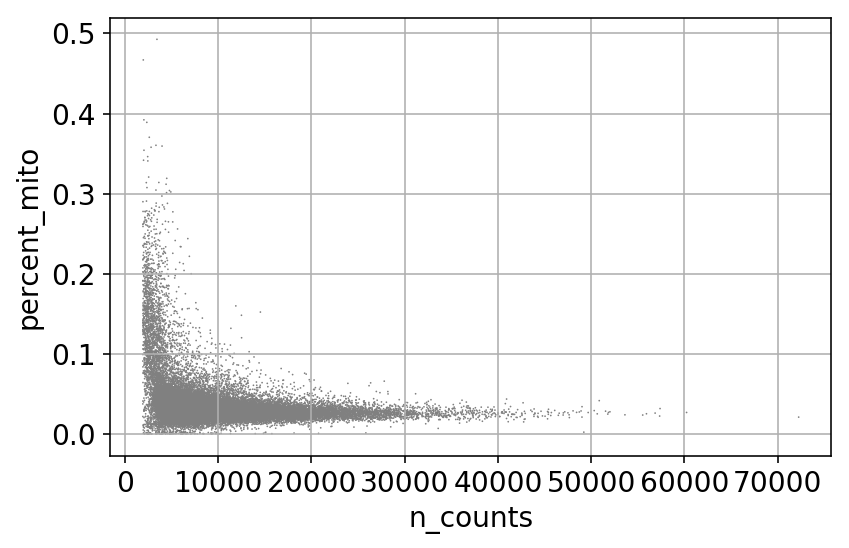

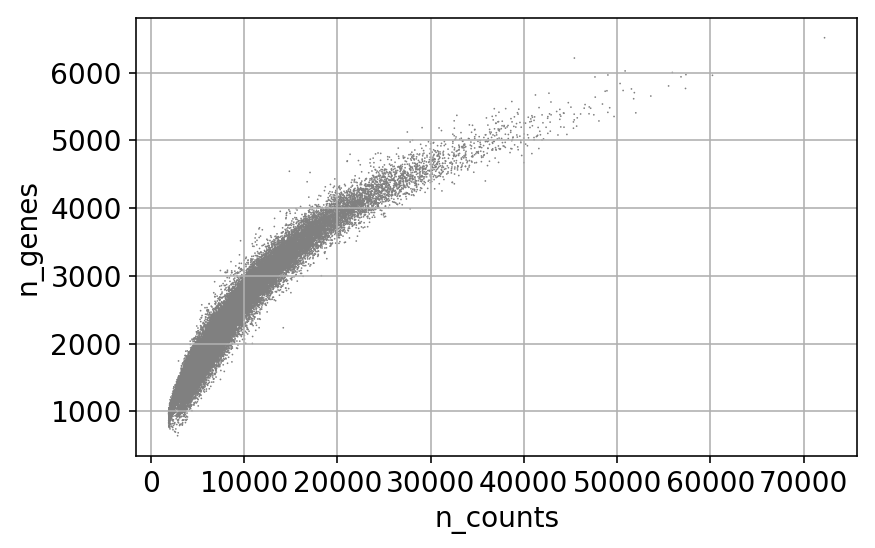

In [17]:
axs = sc.pl.scatter(Tcells_data, x='n_counts', y='percent_mito')
axs = sc.pl.scatter(Tcells_data, x='n_counts', y='n_genes')

In [18]:
sc.pp.filter_genes(Tcells_data, min_counts=1)  # only consider genes with more than 1 count
sc.pp.normalize_per_cell(Tcells_data)          # normalize with total UMI count per cell

In [89]:
print(Tcells_data.X.shape)

(40557, 21800)


In [11]:
sc.write('Tcells_nor', Tcells_data)

### Select HVGs

In [19]:
%%time
filter_result_Tcells = sc.pp.filter_genes_dispersion(Tcells_data.X, flavor='cell_ranger', n_top_genes=1000, log=False)
sc.logging.print_memory_usage()

Memory usage: current 9.51 GB, difference +8.90 GB
CPU times: user 3.98 s, sys: 2.49 s, total: 6.47 s
Wall time: 6.48 s


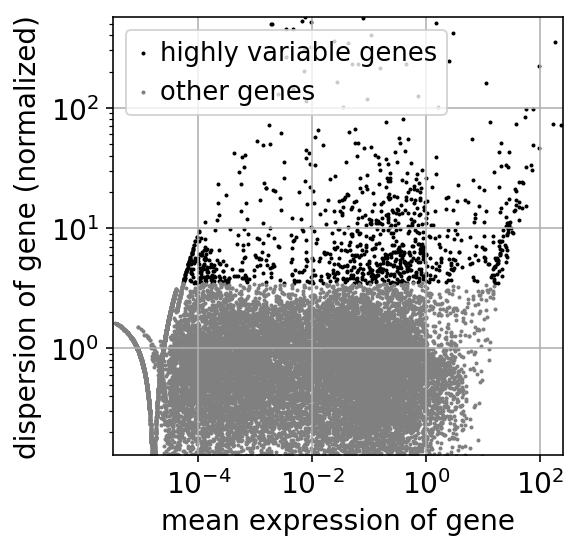

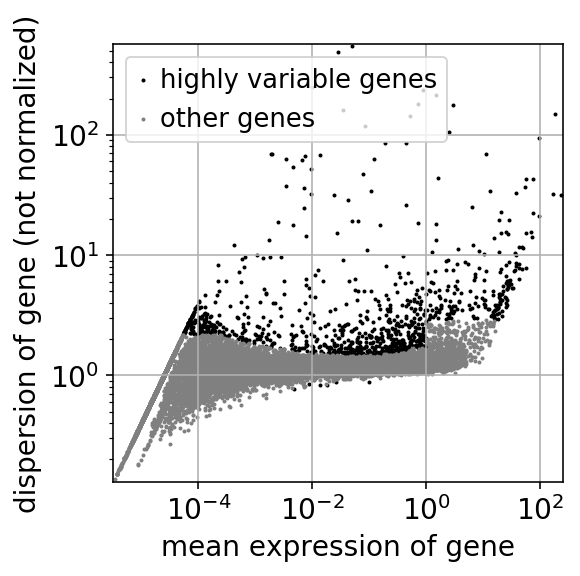

In [22]:
sc.pl.filter_genes_dispersion(filter_result_Tcells, log=True)

In [20]:
Tcells_data = Tcells_data[:, filter_result_Tcells.gene_subset] 

In [21]:
%%time
sc.pp.log1p(Tcells_data)
Tcells_data = sc.pp.regress_out(Tcells_data, ['n_counts', 'percent_mito'], copy=True)
sc.pp.scale(Tcells_data)
sc.logging.print_memory_usage()


Memory usage: current 1.18 GB, difference -8.33 GB
CPU times: user 5min 21s, sys: 4.73 s, total: 5min 26s
Wall time: 5min 26s


### PCA

In [22]:
%%time
sc.tl.pca(Tcells_data, n_comps=50)
sc.logging.print_memory_usage()

Memory usage: current 1.20 GB, difference +0.02 GB
CPU times: user 2min, sys: 4.29 s, total: 2min 4s
Wall time: 21.5 s


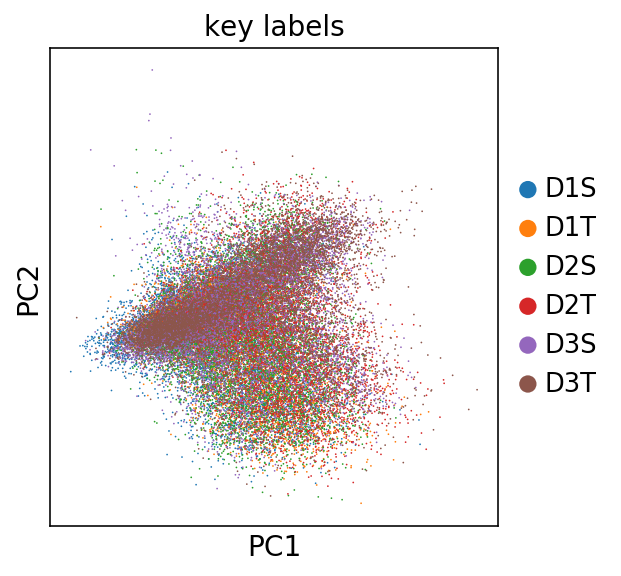

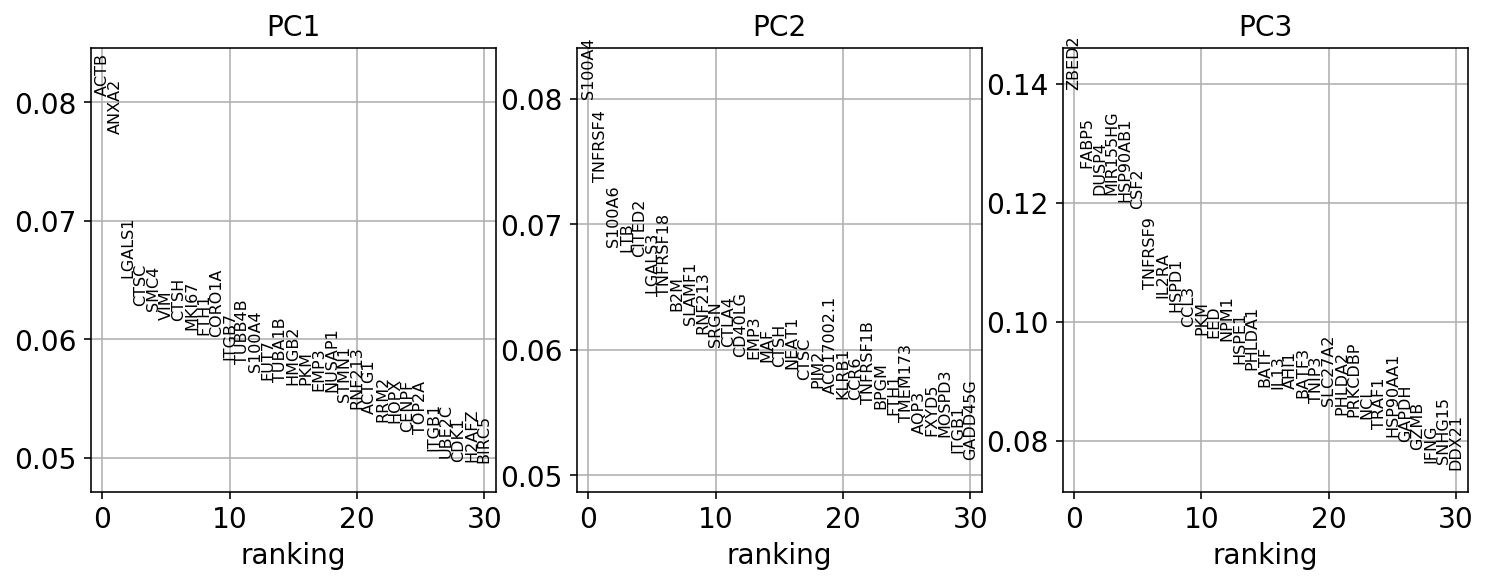

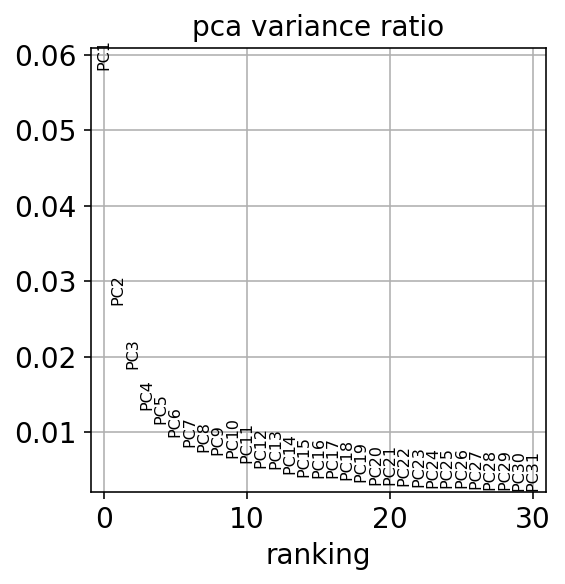

In [26]:
sc.pl.pca(Tcells_data, components= '1,2', color='key_labels')

### TSNE

In [23]:
%%time
sc.tl.tsne(Tcells_data,n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 1.23 GB, difference +0.03 GB
CPU times: user 42min 10s, sys: 1h 22min 37s, total: 2h 4min 47s
Wall time: 3min 31s


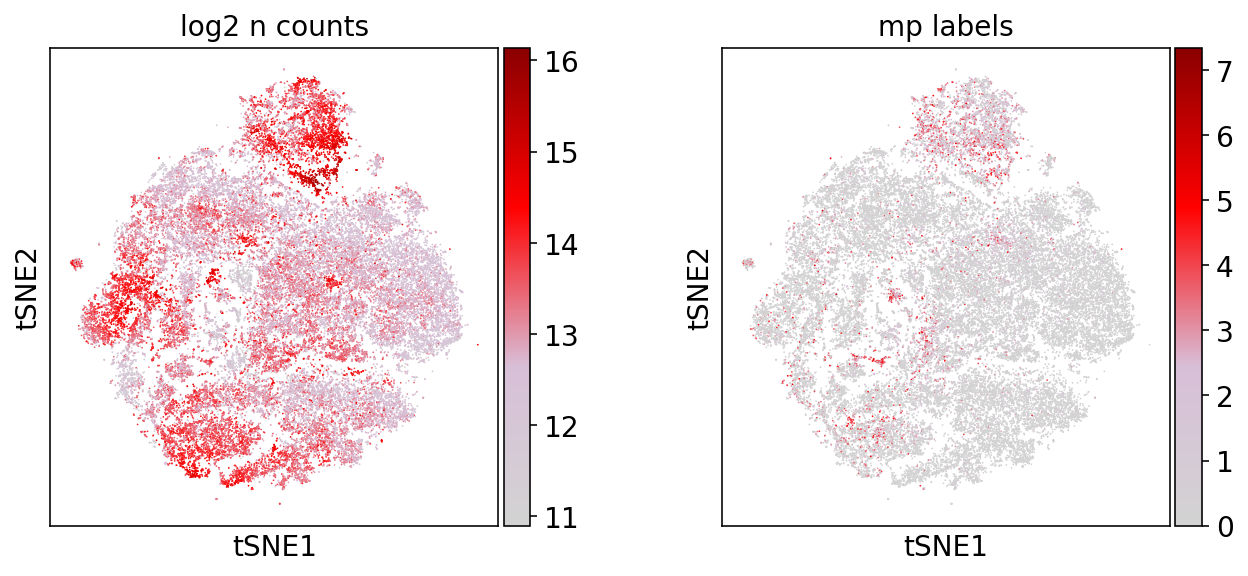

In [32]:
axs = sc.pl.tsne(Tcells_data, color=['log2_n_counts', 'mp_labels'], legend_loc='right margin', color_map=cmap)

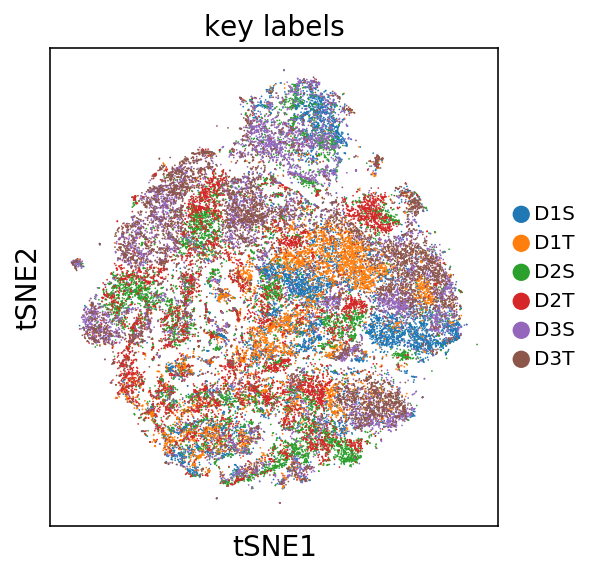

In [30]:
axs = sc.pl.tsne(Tcells_data, color='key_labels', legend_loc='right margin', legend_fontsize=10)

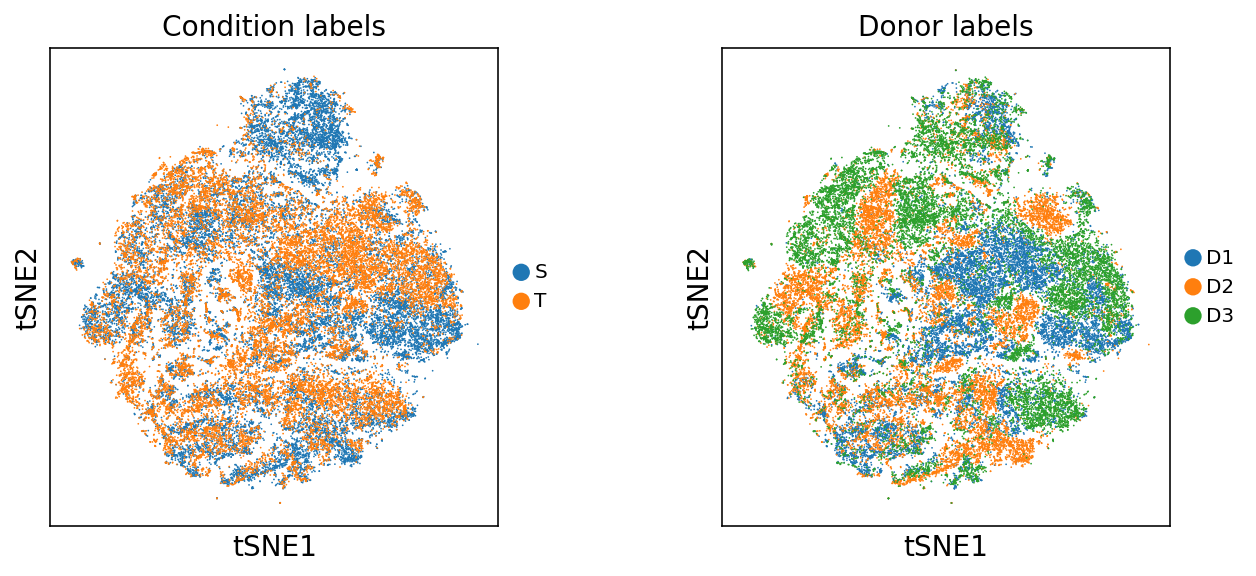

In [31]:
axs = sc.pl.tsne(Tcells_data, color=['Condition_labels', 'Donor_labels'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

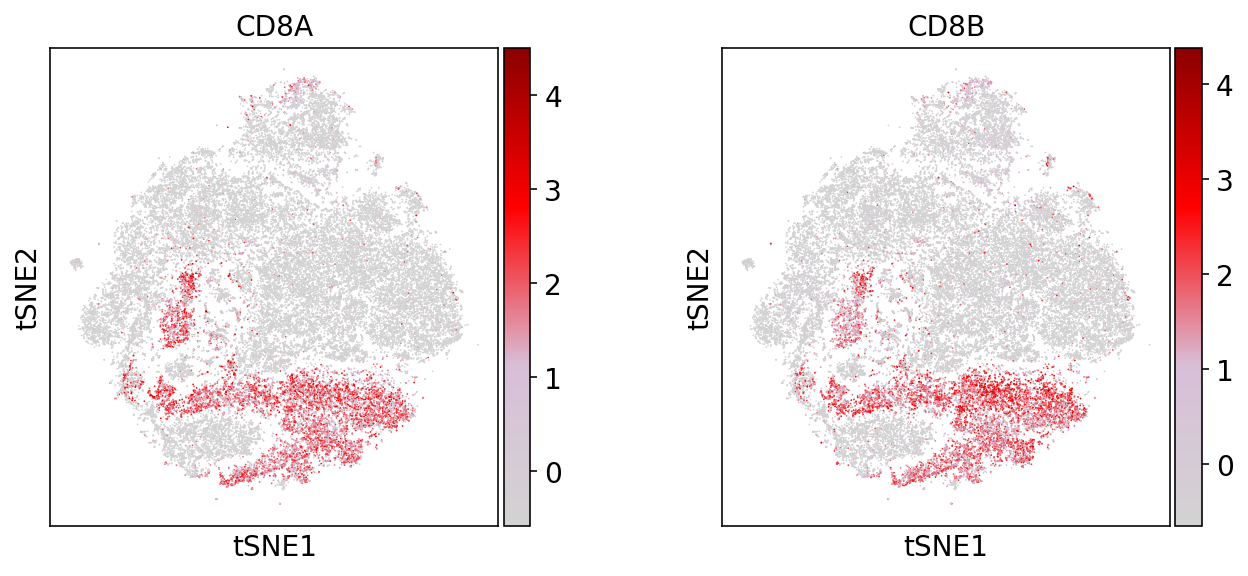

In [33]:
axs = sc.pl.tsne(Tcells_data, color=['CD8A', 'CD8B'], legend_loc='right margin', legend_fontsize=10, color_map=cmap)

### Louvain clustering

In [4]:
Tcells_data.X.shape

(40557, 999)

In [26]:
%%time
sc.tl.louvain(Tcells_data, resolution=0.4, n_jobs=40)
sc.logging.print_memory_usage()

Memory usage: current 1.59 GB, difference +0.00 GB
CPU times: user 49.8 s, sys: 240 ms, total: 50 s
Wall time: 50 s


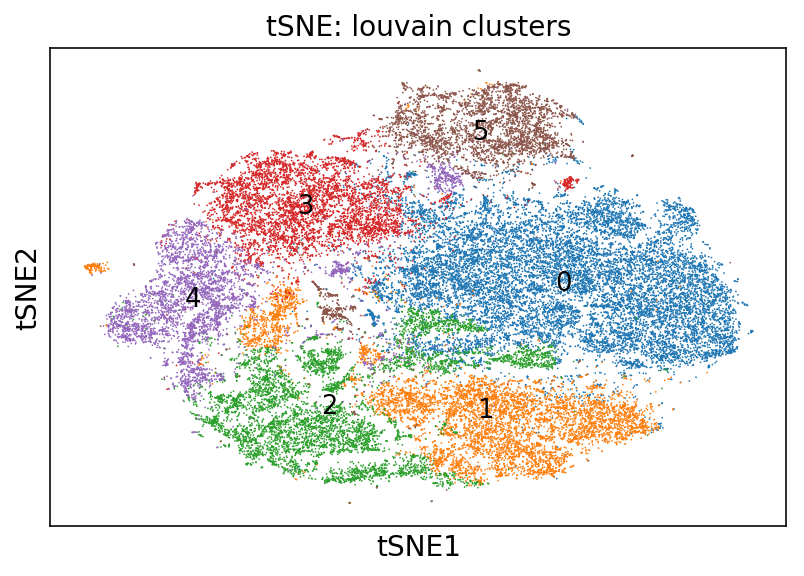

In [27]:
axs = sc.pl.tsne(Tcells_data, color=['louvain_groups'], legend_loc='on data', title='tSNE: louvain clusters')

In [42]:
Tcells_data.write('../write_new/Tcells_corrected.h5ad')

# Cell cycle analysis

In [4]:
Tcells_data = sc.read('../write_new/Tcells_corrected.h5ad')

In [5]:
import anndata
adata = anndata.AnnData(X=Tcells_data.raw.X, var=Tcells_data.raw.var, obs=Tcells_data.obs)

In [6]:
sc.pp.scale(adata)

In [7]:
cell_cycle_genes = [x.strip() for x in open('../regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
print(adata.obs['phase'].value_counts())
# save cell cycle results
np.savetxt('phase.txt', adata.obs['phase'], delimiter='\t', fmt='%s')
np.savetxt('S_score.txt', adata.obs['S_score'], delimiter='\t')
np.savetxt('G2M_score.txt', adata.obs['G2M_score'], delimiter='\t')

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:02:18)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:02:11)
-->     'phase', cell cycle phase (adata.obs)
G1     22488
S      10664
G2M     7405
Name: phase, dtype: int64


In [8]:
Tcells_data.obs['phase'] = np.genfromtxt('phase.txt', delimiter='\t', dtype=str)
Tcells_data.obs['S_score'] = np.genfromtxt('S_score.txt', delimiter='\t')
Tcells_data.obs['G2M_score'] = np.genfromtxt('G2M_score.txt', delimiter='\t')

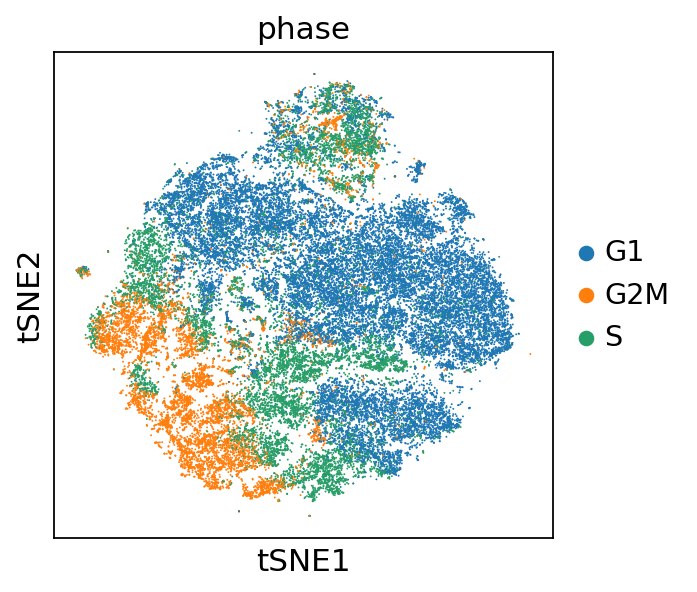

In [11]:
sc.pl.tsne(Tcells_data, color=['phase'], save='_phase.pdf')

In [10]:
Tcells_data.write('../write_new/Tcells_corrected.h5ad')